# Event separation

## Importation

In [103]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from functools import partial
import seaborn as sns
import calendar

## Data Treatment

In [204]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon']
stat_index = 1
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)

# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']

df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')


## Isolating the events

In [205]:
events_pd = np.zeros(len(df[value_column]))
time_limit = 6*24
in_index = False
time_count = 0
event_count = 1
index = 0
years = df['time'].dt.year.unique()

for i, p in enumerate(df[value_column]):
    if p != 0:
        time_count = 0
        if in_index == False:
            in_index = True
            index = i            
    if p == 0:
        time_count += 1
        if time_count >= time_limit and in_index == True:
            in_index = False
            events_pd[index:i-time_limit+1] = event_count
            event_count += 1

df['events'] = events_pd

## Treating the events data

In [206]:
events_sum = df.groupby('events')[value_column].sum()
events_sum_pd = np.zeros(shape=[len(df[value_column])])
for i, e in enumerate(df['events']):
    events_sum_pd[i] = events_sum[int(e)]
df['events_sum'] = events_sum_pd

In [219]:
start_times = df.groupby('events')['time'].min()
end_times = df.groupby('events')['time'].max()
durations = np.array((end_times - start_times).dt.total_seconds())/(60*60)+(1/6)
time_btwn_events = np.zeros(len(start_times)-2)
for i in range(len(start_times)):
   if i>1:
    time_btwn_events[i-2] = (start_times[i] - end_times[i-1]).total_seconds()/(60*60)

events = df.groupby('events')['events_sum'].first().values
# Deleting the 0 event -> corresponding to time without rain
durations = np.delete(durations,0)
events = np.delete(events,0)
start_times = np.delete(start_times,0)
Intensities = events/durations
time_ratio = Intensities[:-1]/time_btwn_events

# Test of looking at the evolution through the years of the cumul of subhourly rains -> Doesn't lead to any trend
width_mobile = 1
num_mobile = years[-1]-years[0]-width_mobile
cumul_intensity_sr = np.zeros(shape=[num_mobile])
for i in range(num_mobile):
  mask = (start_times<=np.datetime64(str(years[0]+i+width_mobile)+'-01-01')) & (start_times>=np.datetime64(str(years[0]+i)+'-01-01')) & (durations < 0.5)
  cumul_intensity_sr[i] = np.sum(events[mask])

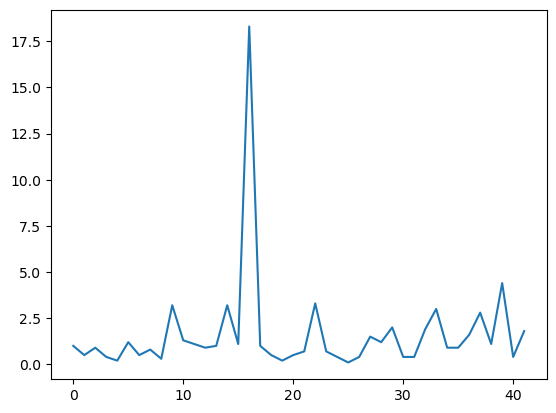

In [220]:
plt.plot(cumul_intensity_sr)

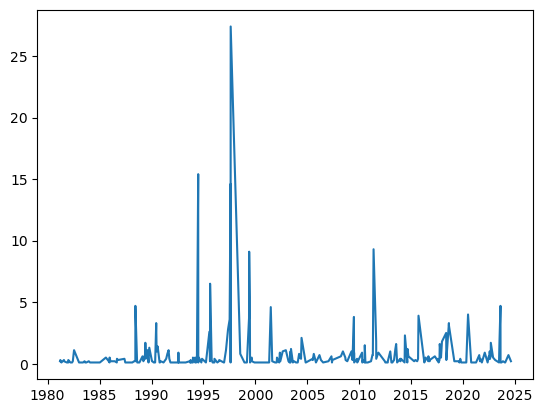

In [221]:
plt.plot(start_times[durations<1],events[durations<1], '-')

## Test of FFT on the event time serie

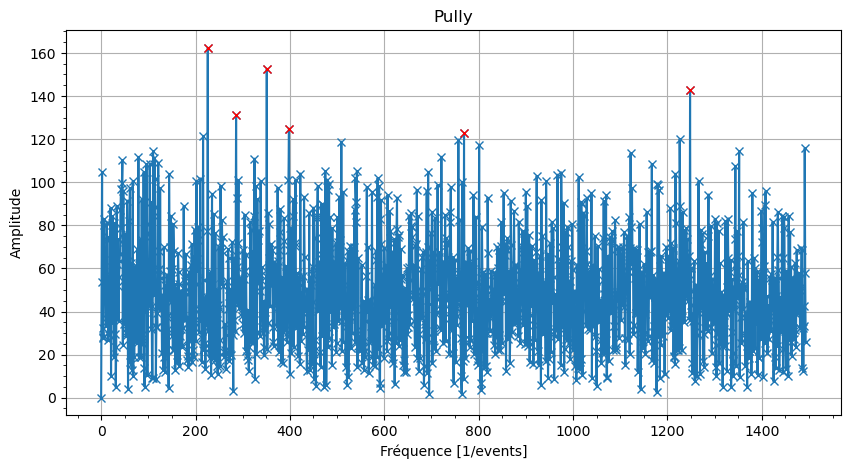

In [217]:
signal = (np.array(events) - np.mean(events))/np.std(events)
fft_vals = np.fft.fft(signal)
fft_freqs = np.fft.fftfreq(len(signal), 1/len(signal))

half_n = len(signal) // 2
fft_vals_clean = np.abs(fft_vals[:half_n])
fft_freqs_clean = fft_freqs[:half_n]

high_val_filter = 0
high_freq_filter = 100

plt.figure(figsize=(10, 5))
plt.plot(fft_freqs_clean[fft_vals_clean>high_val_filter], fft_vals_clean[fft_vals_clean>high_val_filter], 'x-')
plt.plot(fft_freqs_clean[fft_vals_clean>np.max(fft_vals_clean*0.75)], fft_vals_clean[fft_vals_clean>np.max(fft_vals_clean*0.75)], 'xr')
plt.title("Spectre de fréquence")
plt.xlabel("Fréquence [1/events]")
plt.ylabel("Amplitude")
plt.title(Stations[stat_index])
plt.minorticks_on()
plt.grid(True)
plt.show()

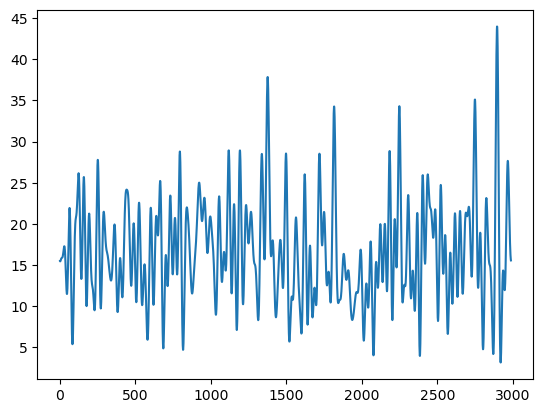

In [218]:
fft_vals[np.abs(fft_vals)<high_val_filter] = 0
fft_vals[np.abs(fft_freqs)>high_freq_filter] = 0
new_signal = np.real(np.fft.ifft(fft_vals))*np.std(events)+np.mean(events)
plt.plot(new_signal)